# Data exploration

### Setup

In [ ]:
pip install -U -r requirements.txt

### Getting data from s3

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('home_search.data')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21960 entries, 0 to 21959
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               21960 non-null  int64  
 1   postcode                 21960 non-null  object 
 2   bedrooms                 21960 non-null  int64  
 3   main_type                21960 non-null  object 
 4   second_level_type        21938 non-null  object 
 5   footprint_area_sqm       21951 non-null  float64
 6   abshmin                  21943 non-null  float64
 7   absh2                    21941 non-null  float64
 8   abshmax                  21943 non-null  float64
 9   relh2                    21941 non-null  float64
 10  relhmax                  21943 non-null  float64
 11  internal_floor_area_sqm  21806 non-null  float64
 12  chain_1_hash             17152 non-null  object 
dtypes: float64(7), int64(2), object(4)
memory usage: 2.2+ MB


### Ideas for investigation
- [x] Check for Null values
    - There are quite a few missing values in **chain_1_hash** (we can keep it along until observing its informativeness else we can drop this column. 
    - For other columns nan values are low proportion of total so we can potentially just drop nan rows from these columns for simplicity
- [x] Check for correlated features and drop some of them
- [x] Check feature information (considering classification task)
- [x] Target variable analysis (considering classification task), verify correct stratification
- [x] Start with low penalisation on parametric models as they may naturally underfit on this sufficiently large dataset
- [ ] Check for feature importance 
- [x] Try Boosting and tune it for better accuracy
- [ ] Identify mis classified instances focusing on specific class using Confusion matrix and feature engineer to fix mis classifications
- [ ] Try RFECV on promising models
- [ ] Explore heirarchical Bayesian modelling based on different feature attributes

In [3]:
target = 'bedrooms'
features = df.columns.difference([target])

df_non_na = df.dropna(subset=features.difference(['chain_1_hash'])) # Drop na values using all feature columns except chain_1_hash
X,y = df_non_na[features], df_non_na[target]

### Checking correlation between features (using numeric features only)

We can identify collinearity between features and drop some of them to avoid instabilities in the models later on

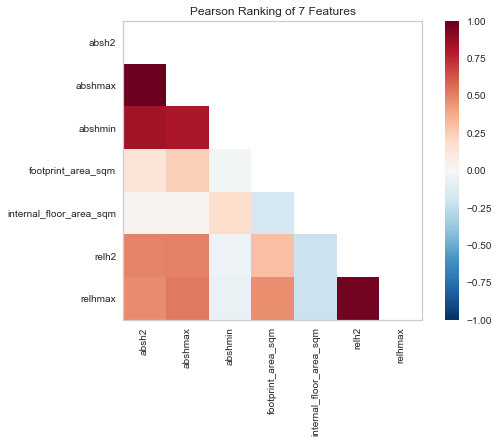

<AxesSubplot:title={'center':'Pearson Ranking of 7 Features'}>

In [4]:
from yellowbrick.features import Rank2D

X_numeric_ = X.select_dtypes(np.double)
visualizer = Rank2D(algorithm='pearson')
visualizer.fit_transform_show(X_numeric_, outpath="./images/pearson_correlation_numeric_features.png", )

visualizer.show()

- It makes sense that relh2 and relhmax are correlated and so are absh2 and abshmax. For these variables we can potentially just take one and drop the other 
- To a significant degree abshmin happens to be correlated with absh2 and abshmax. We can explore this in slight more detail before making a decision

C:\Users\MZ9UTE\Miniconda3\envs\bedroom-prediction\lib\site-packages\yellowbrick\base.py:244: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "title" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(outpath, **kwargs)


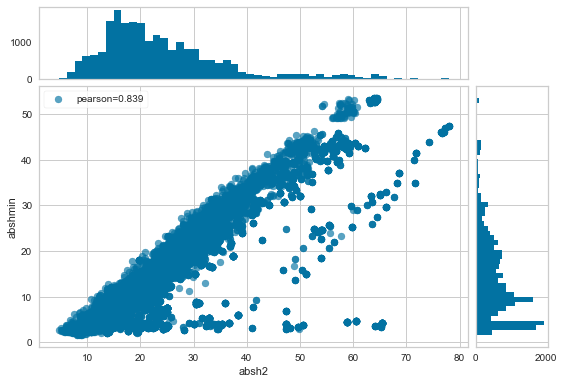

<AxesSubplot:xlabel='absh2', ylabel='abshmin'>

In [5]:
from yellowbrick.features import JointPlotVisualizer

columns = ['absh2', 'abshmin']
visualizer = JointPlotVisualizer(columns=columns)
visualizer.fit_transform_show(X_numeric_,y, outpath='./images/absh2_vs_abshmin.png', title='Relationship between absh2 and abshmin')
visualizer.show(title='Relationship between absh2 and abshmin')

Looking at the plot it appears that `abshmin` encodes slightly more information than absh2 being bimodal so we can keep this and **drop absh2 and abshmax**. We will also keep `relhmax` and these both should approximately capture the effect of elevation and build height

In [6]:
numeric_columns_to_drop = ['relh2', 'absh2', 'abshmax']
numeric_features = X_numeric_.columns.difference(numeric_columns_to_drop)


### Checking informativeness in features

In [7]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

X,y = df.dropna()[features], df.dropna()[target]

high_cardinality_features = ['chain_1_hash', 'postcode']
categorical_features = [f for f in df.select_dtypes(['object']).columns if (f not in high_cardinality_features)]

one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
ordinal_encoder = OrdinalEncoder()

column_transformer = ColumnTransformer([('numeric_data', 'passthrough', numeric_features), 
                                       ('categorical_data', one_hot_encoder, categorical_features),
                                       ('high_cardinality_features', ordinal_encoder, high_cardinality_features)])

Xt = column_transformer.fit_transform(X)

C:\Users\MZ9UTE\Miniconda3\envs\bedroom-prediction\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


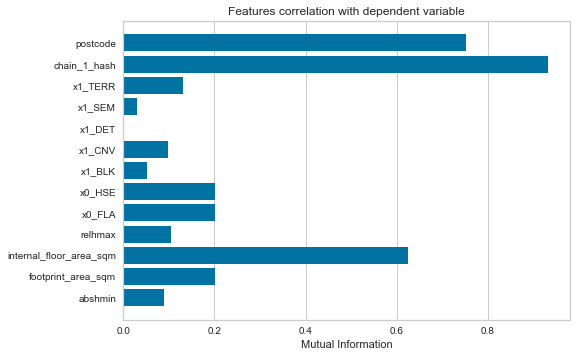

<AxesSubplot:title={'center':'Features correlation with dependent variable'}, xlabel='Mutual Information'>

In [8]:
from yellowbrick.target import FeatureCorrelation

feature_names = list(numeric_features) + list(column_transformer.named_transformers_['categorical_data'].get_feature_names()) + high_cardinality_features
discrete = [False]*len(numeric_features) + [True]*(Xt.shape[1] - len(numeric_features))
visualizer = FeatureCorrelation(method='mutual_info-classification', labels=feature_names)
visualizer.fit(Xt, y, discrete_features=discrete, random_state=0)
visualizer.show(outpath='./images/mutual_info_for_classification_task.png')
visualizer.show()

Earlier it was suggested that we may drop `chain_1_hash` because it has many NaN values which can't realistically be imputed. 
However, this column has much information about target variable and instead of losing all that information we prefer to model houses that do not have this information separately (or working with models that can incorporate missing values natively).
This is also important because dropping *NaN* value rows on the basis of `chain_1_hash` removes data about **Detached** houses entirely (blank row on chart).

### Target analysis

Ideally for the nature of target variable (counts) we would approach the problem as some version of **Poisson regression**.
However, it is important to not have an error of even single bedroom in our predictions means we can frame the problem as a classification problem and try to achieve high accuracy on the classification task.

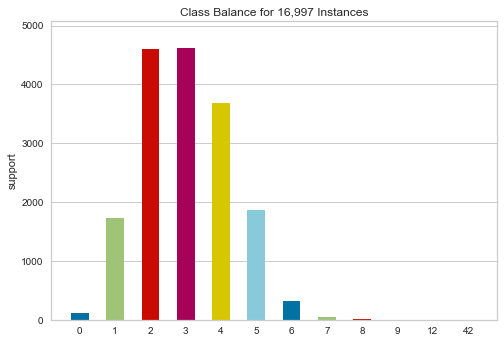

Unique values in target: 
 3     4619
2     4605
4     3676
5     1860
1     1738
6      321
0      120
7       48
8        7
12       1
9        1
42       1
Name: bedrooms, dtype: int64


In [9]:
from yellowbrick.target import ClassBalance

visualizer = ClassBalance()
visualizer.fit(y).show(outpath="./images/bedrooms_class_imbalance.png")
visualizer.show()
print('Unique values in target: \n', y.value_counts(sort=True))

Since the distribution of classes being non-uniform a proper train-test split should be used (Stratified for simplicity).  
The test set can be reserved until we arrive at a sufficiently satisfactory model and evaluate final performance on this set.  
Because we will need to do a lot of cross validation we'll not keep the test set size un necessarily large.

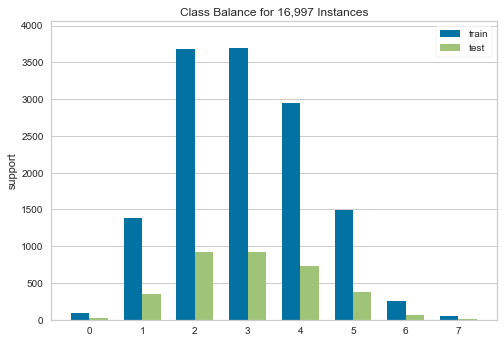

<AxesSubplot:title={'center':'Class Balance for 16,997 Instances'}, ylabel='support'>

In [10]:
from sklearn.model_selection import train_test_split

yt = y.copy()
yt.loc[y>6] = 7 # Need to label all the classes with single instances to some common value to allow stratified splits
X_train, X_test, y_train, y_test = train_test_split(Xt, yt,
                                                    stratify=yt, 
                                                    test_size=0.20)
    
visualizer = ClassBalance()
visualizer.fit(y_train, y_test).show(outpath='./images/stratified_train_test_split.png')
visualizer.show()

We appear to have a sensible split of training and test data and can progress to modelling from here.

### Modelling

We can start with a simple model which we can consider as baseline and then build more complex models successively improving the scores

**Assumptions**
- We don't wan't to focus on any particular class we can just assume `accuracy` as a good metric to optimise
- Because the dataset has large number of instances and quite a few features, it is likely that parametric models may underfit the data. Hence we'll start with minimal regularisation
- We will first build a suitable model with `chain_1_hash` included and then move on to model instances that have `chain_1_hash` value missing. If needed we can then merge 2 models into 1 composite 

### Baseline model
To start with we'll model the problem with a `DummyClassifier` to get a handle on lower bounds of performance and keep track of incremental improvements

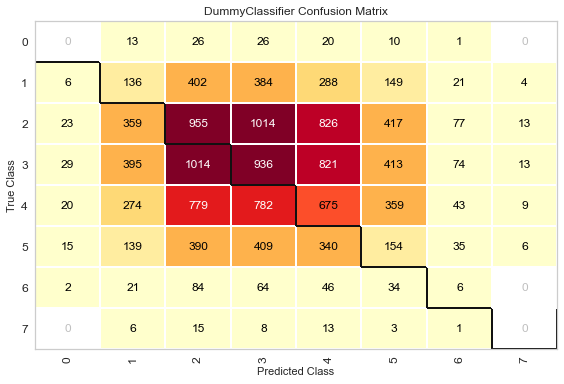

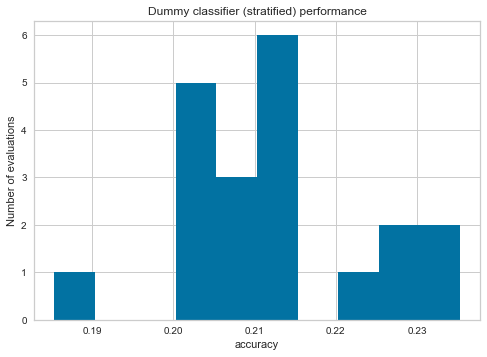

In [11]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import cross_val_score

model = DummyClassifier(strategy='stratified')

pipe = Pipeline([('model', model)])

visualizer = ConfusionMatrix(pipe, support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_train, y_train)
visualizer.show(outpath="./images/dummy_classifier_confusion_matrix.png")
visualizer.show()
cv_score_dummy = cross_val_score(pipe, X_train, y_train, cv=20, scoring='accuracy')

plt.hist(cv_score_dummy)
plt.title("Dummy classifier (stratified) performance")
plt.xlabel("accuracy")
plt.ylabel("Number of evaluations")
plt.savefig("./images/dummy_classifier_performance.png")

This model makes reasonable assumption of predicting class instances in the ration in which they appear in traininng data. 
To take into account the stochastic nature of train-test split we'll use `cross_val_score` to evaluate this model.
Multiple evaluations with `cross_val_score` give us a distribution of accuracy where variance is the effect of randomness in how the data is split.

### Linear model

* For simplicity we can start with a linear model (Logistic regression). It is preferred since it can account for categorical variables in our data as compared to LDA which would have been an alternate choice since it could account for prior class probabilities more explicitly which could be desirable sometimes.
* For robust estimation of coefficients it is needed that input variables be scaled and PCA be applied to get rid of correlations among features
* Since we know that there are many features and sufficiently large number of training instances, this model will naturally underfit the data hence we do not regularise the model.


`Note:` Enable Intel scikit learn extension for fast training on Intel based CPU. Comment out the following lines if subsequent training gives error because of missing packages

In [12]:
from sklearnex import patch_sklearn
patch_sklearn() # Patch all scikit learn estimators to enable faster training where supported 

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


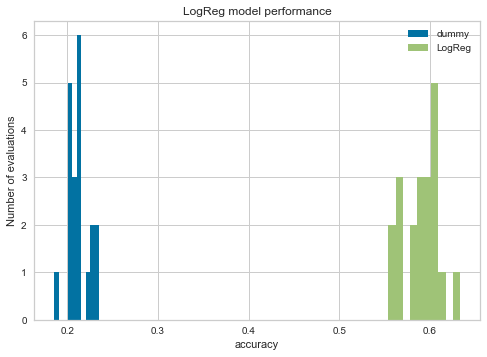

In [13]:
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA


model = LogisticRegression(max_iter=500, C=100)

pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('model', model)])

cv_score_logreg = cross_val_score(pipe, X_train, y_train, cv=20, scoring='accuracy', n_jobs=-1)
plt.hist(cv_score_dummy, label='dummy')
plt.hist(cv_score_logreg, label='LogReg')
plt.title("LogReg model performance")
plt.xlabel("accuracy")
plt.ylabel("Number of evaluations")
plt.legend()
plt.savefig("./images/dummy_classifier_vs_logreg.png")

There is clear improvement over `DummyClassifier` (even accounting for variance due to randomness in data splitting) and this may be due to the fact that the decision boundaries in higher dimensional space are actually simple enough to be captured by linear model. There is however room for much improvement.  
Let's check the bias-variance behavour of the model


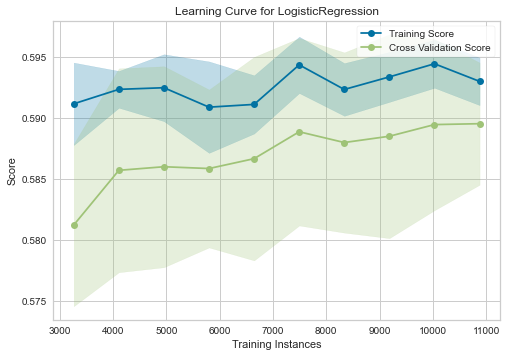

<AxesSubplot:title={'center':'Learning Curve for LogisticRegression'}, xlabel='Training Instances', ylabel='Score'>

In [14]:
from yellowbrick.model_selection import LearningCurve
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)

visualizer = LearningCurve(
    pipe, cv=cv, scoring='accuracy', train_sizes=sizes, n_jobs=-1
)

visualizer.fit(X_train, y_train)
visualizer.show(outpath="./images/logreg_learning_curve.png")
visualizer.show()

Both the training and CV scores are low albeit close, meaning that our model is underfitting rather than overfitting the training data. Although adding more training instances does not still improve the training score, meaning that we probably have enough number of instances to work with but our features do not have enough predictive power.  
This observation alone prompts us to do some feature engineering.  
One common way is to include some non linearity and some feature interactions in the model by including polynomial transformation of feature vectors.

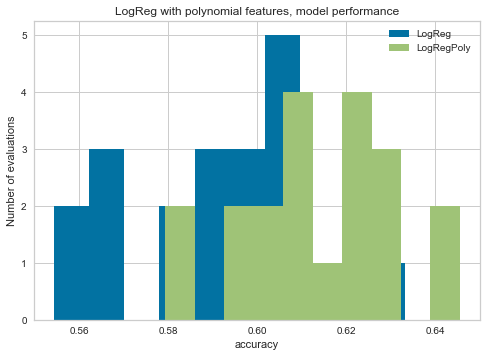

In [15]:
from sklearn.preprocessing import PolynomialFeatures

pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA()), ('poly_features', PolynomialFeatures(3)), ('model', model)])

cv_score_logreg_poly = cross_val_score(pipe, X_train, y_train, cv=20, scoring='accuracy', n_jobs=-1)
plt.hist(cv_score_logreg, label='LogReg')
plt.hist(cv_score_logreg_poly, label='LogRegPoly')
plt.title("LogReg with polynomial features, model performance")
plt.xlabel("accuracy")
plt.ylabel("Number of evaluations")
plt.legend()
plt.savefig("./images/logreg_vs_logreg_poly.png")

As an experiment polynomial of degree 3 is trialled along with feature interactions, this does not seem to increase the score all that much and so the model structurally cannot improve much unless extensive feature engineering is performed e.g. spline transformations etc.
At this point we can try more complex models which may be less interpretable but more flexible and accurate.

### Ensemble model

As compared to linear model it is expected that the ensemble model `GradientBoost` should perform better due to inherently capturing complex feature interactions as well correcting on errors by building successively un correlated trees.  
Another benefit with `GBM` is they can handle missing values natively and we do not need to build separate model for missing values in `chain_1_hash`

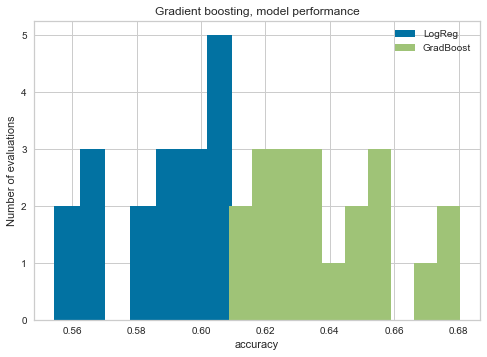

In [69]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()

cv_score_gb = cross_val_score(model, X_train, y_train, cv=20, scoring='accuracy', n_jobs=-1)
plt.hist(cv_score_logreg, label='LogReg')
plt.hist(cv_score_gb, label='GradBoost')
plt.title("Gradient boosting, model performance")
plt.xlabel("accuracy")
plt.ylabel("Number of evaluations")
plt.legend()
plt.savefig("./images/logreg_vs_gradboost.png")
plt.show()

visualizer = ConfusionMatrix(model, support=True)

visualizer.fit(X_train, y_train)
visualizer.score(X_train, y_train)
visualizer.show(outpath="./images/gradboost_confusion_matrix.png")
visualizer.show()

Model has realistic improvements even accounting for variance in accuracy estimation due to data splits, but it could be further tuned to get more accurate as a first step. We have to identify however if the model is overfitting or likely underfitting the data

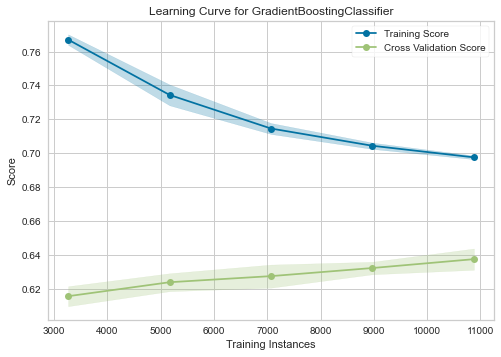

<AxesSubplot:title={'center':'Learning Curve for GradientBoostingClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [17]:
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 5)

visualizer = LearningCurve(
    model, cv=cv, scoring='accuracy', train_sizes=sizes, n_jobs=-1
)

visualizer.fit(X_train, y_train)
visualizer.show(outpath="./images/gradboost_learning_curve.png")
visualizer.show()

We can see that since the *training curve* is above the *validation curve*, we're significantly overfitting the data using this model.
It can be said that to avoid this overfitting having more samples could help as the curves appear to be slightly converging even when using maximum number of samples.
This indicates a need to introduce regularisation for better generalising the model fit.
We can start by decreasing number of stages in the ensemble build and observe the effect.

C:\Users\MZ9UTE\Miniconda3\envs\bedroom-prediction\lib\site-packages\yellowbrick\base.py:244: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "title" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(outpath, **kwargs)


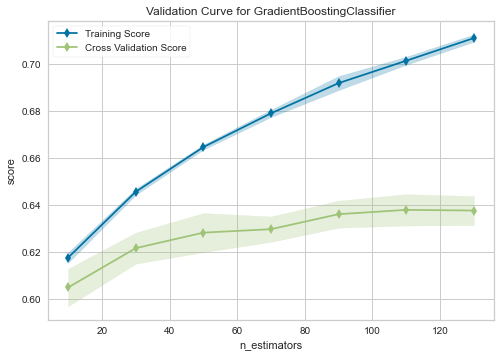

<AxesSubplot:title={'center':'Validation Curve for GradientBoostingClassifier'}, xlabel='n_estimators', ylabel='score'>

In [18]:
from yellowbrick.model_selection import ValidationCurve

visualizer = ValidationCurve(
    model, param_name="n_estimators",
    param_range=np.arange(10, 150, 20), cv=5, scoring="accuracy", n_jobs=-1
)

visualizer.fit(X_train, y_train)
visualizer.show(outpath="./images/gradboost_n_estimators_tuning.png")
visualizer.show()

It appears that the *validation scores* start flattenning out after 50 stages and *training score* stronngly starts to diverge from this point so we'll limit the ensemble there.  
Reducing the number of samples used in individual stages also strongly regularises the ensembles so we can experiment with this

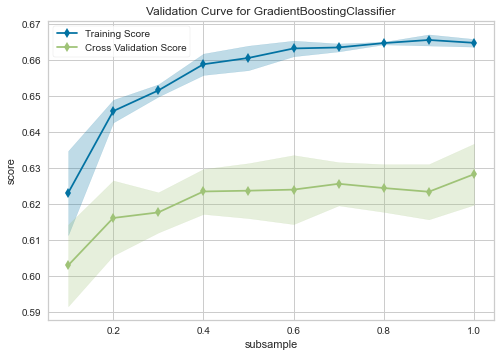

<AxesSubplot:title={'center':'Validation Curve for GradientBoostingClassifier'}, xlabel='subsample', ylabel='score'>

In [19]:
model = GradientBoostingClassifier(n_estimators=50)

visualizer = ValidationCurve(
    model, param_name="subsample",
    param_range=np.linspace(0.1, 1, 10), cv=5, scoring="accuracy", n_jobs=-1
)

visualizer.fit(X_train, y_train)
visualizer.show(outpath="./images/gradboost_subsample_tuning.png")
visualizer.show()

At around `subsample` = 0.4 the capability of ensemble to generalise well saturates, however increasing this value does not result in diverging curves and hence there is no benefit in changing this from default value  
As a last option we'll tweak `min_samples_leaf`, increasing this value should introduce more regularisation in the system

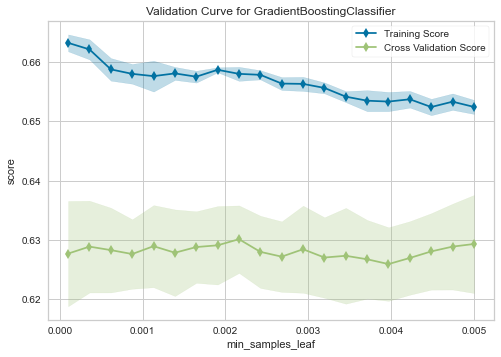

<AxesSubplot:title={'center':'Validation Curve for GradientBoostingClassifier'}, xlabel='min_samples_leaf', ylabel='score'>

In [20]:
model = GradientBoostingClassifier(n_estimators=50)

visualizer = ValidationCurve(
    model, param_name="min_samples_leaf",
    param_range=np.linspace(0.0001, 0.005, 20), cv=5, scoring="accuracy", n_jobs=-1
)

visualizer.fit(X_train, y_train)
visualizer.show(outpath="./images/gradboost_min_samples_leaf_tuning.png")
visualizer.show()

This largely shows no impact (on *validation score*) and we can conclude that limiting number of stages has already regularised model quite enough. We can look into more granular level now at misclassified instances to see if there is a pattern and if it can be used to correct model in the correct direction.

At this point it is recommended to use `GradientBoostClassifier` model since it does overfit on training data meaning it has the fleibility to capture patterns in the data. However, with proper generalisation and error investigation this can be limited and *validation* score can be improved.